In [1]:
import numpy as np
import xarray as xr
from glob import glob
import copy

from oceanmixedlayers import oceanmixedlayers
import gsw as gsw

import matplotlib.pyplot as plt
import matplotlib as mpl
import cmocean

from Paths import Figure_Save_Path, Argo_Path, SST_Path

%matplotlib inline


def IsVarThere(hndl,VAR):
    CHECK = [A for A in hndl.data_vars  if A==VAR]
    return len(CHECK)>0


plt.rcParams["font.family"] = "Serif"

OK
OK


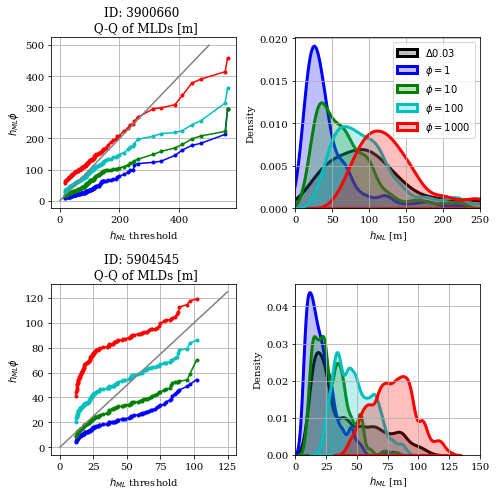

In [2]:
# Load in some Argo data for examples of using the omld package
#PATH = Argo_Path+'/dac/aoml/3900331/'
#PATH = Argo_Path+'/dac/aoml/3900451/'
PATH = Argo_Path+'/dac/aoml/3900660/'
#Holte and Talley sample
#PATH = Argo_Path+'/dac/aoml/3900621/'


PROFFILE = glob(PATH+'/*_prof.nc')

with xr.open_dataset(PROFFILE[0]) as hndl:

    if ( (IsVarThere(hndl,'TEMP'))&(IsVarThere(hndl,'PSAL'))):
        print('OK')
        NP = hndl.N_PROF.size
        NZ = hndl.N_LEVELS.size
        Z_c_2d       = np.zeros([NP,NZ])+np.NaN
        dZ_2d        = np.zeros([NP,NZ])+np.NaN
        P_c_2d       = np.zeros([NP,NZ])+np.NaN
        dP_2d        = np.zeros([NP,NZ])+np.NaN
        CT_c_2d      = np.zeros([NP,NZ])+np.NaN
        PSal_c_2d    = np.zeros([NP,NZ])+np.NaN
        dRho0dz_c_2d = np.zeros([NP,NZ])+np.NaN
        Rho0_c_2d    = np.zeros([NP,NZ])+np.NaN
        GOOD         = np.zeros([NP],dtype=bool)
        for p in range(NP):
            DayQC = float(hndl.JULD_QC[p])
            PosQC = float(hndl.POSITION_QC[p])
            if (np.max(DayQC==np.array([1,2,5,8]))
                and 
                np.max(PosQC==np.array([1,2,5,8]))):
                
                #QC
                SALTQC = np.array(hndl.PSAL_QC[p,:],dtype=float)
                TEMPQC = np.array(hndl.TEMP_QC[p,:],dtype=float)
                PRESQC = np.array(hndl.PRES_QC[p,:],dtype=float)
                
                #Computes in-situ density from T&S, T, or S
                LI = (((SALTQC==1)|(SALTQC==2)|(SALTQC==5)|(SALTQC==8))
                      &
                      ((TEMPQC==1)|(TEMPQC==2)|(TEMPQC==5)|(TEMPQC==8))
                      &
                      ((PRESQC==1)|(PRESQC==2)|(PRESQC==5)|(PRESQC==8)))
                if (np.sum(LI)>20):
                    Pressure = np.array(hndl.PRES[p,:][LI],dtype=float)
                    PSal = np.array(hndl.PSAL[p,:].values[LI],dtype=float)
                    Temp = np.array(hndl.TEMP[p,:].values[LI],dtype=float)
                    GOOD[p]=True
                else:
                    GOOD[p]=False

                if GOOD[p]:
                    Rho = gsw.density.rho_t_exact(PSal,Temp,Pressure)
                    CT = gsw.conversions.CT_from_rho(Rho,PSal,Pressure)[0]
                    Rho0 = gsw.density.rho(PSal,CT,0)
                    
                    #Set a zero surface pressure bin
                    P_i = np.array([0.]+list(Pressure))
                    
                    #First guess at Z_i from pressure
                    Z_i = -1.*P_i
                    dZ = (Z_i[:-1]-Z_i[1:])
                    
                    if (np.min(dZ)<=0 or np.max(dZ)>100):
                        GOOD[p]=False
                    else:

                        CT_i = np.array([CT[0]]+list(CT))
                        PSal_i = np.array([PSal[0]]+list(PSal))
                        Rho0_i = np.array([Rho0[0]]+list(Rho0))

                        P_c       = 0.5*(P_i[1:]+P_i[:-1])
                        dP        = (P_i[:-1]-P_i[1:])
                        CT_c      = 0.5*(CT_i[1:]+CT_i[:-1])
                        PSal_c    = 0.5*(PSal_i[1:]+PSal_i[:-1])
                        Rho0_c    = 0.5*(Rho0_i[1:]+Rho0_i[:-1])
                        dRho0dz_c = (Rho0_i[...,:-1]-Rho0_i[...,1:])/dZ

                        #Get density for layer from mean CT and Psal and central pressure
                        Rho = gsw.density.rho(PSal,CT_c,P_c)
                        #Compute Z_i referenced to a z=0 surface using layer mean density
                        # and assuming hydrostatic pressure
                        for zi in range(len(Rho)):
                            Z_i[zi+1]=Z_i[zi]+1.e4*dP[zi]/(9.81*Rho[zi])
                        Z_c = 0.5*(Z_i[1:]+Z_i[:-1])
                        dZ = (Z_i[:-1]-Z_i[1:])
                        
                        LG = len(Z_c)
                        Energy = 25/9.81
                        CT_c_2d[p,:LG] = CT_c
                        PSal_c_2d[p,:LG] = PSal_c
                        P_c_2d[p,:LG] = P_c
                        Z_c_2d[p,:LG] = Z_c
                        dRho0dz_c_2d[p,:LG] = dRho0dz_c
                        Rho0_c_2d[p,:LG] = Rho0_c
                        dZ_2d[p,:LG] = dZ
                        dP_2d[p,:LG] = dP
Timing = True

if Timing:
    import time

    # Compute the PE anomaly for the threshold MLD
if Timing: time_0=time.time()
MLD_003,MLD_003i = oceanmixedlayers.threshold(P_c_2d[GOOD,:].T,
                                              Rho0_c_2d[GOOD,:].T,
                                              delta=0.03,
                                              ref=10
                                             )  
    
# Compute a series of MLDs using the PE anomaly asuming constant Rho0 over a layer
if Timing: time_5=time.time()
MLD_pe_1 = oceanmixedlayers.mld_pe_anomaly(Z_c_2d[GOOD,:].T,
                                         dZ_2d[GOOD,:].T,
                                         Rho0_c_2d[GOOD,:].T,
                                         energy=1.,
                                         gradient=False
                                        )

# Compute a series of MLDs using the PE anomaly asuming constant Rho0 over a layer
if Timing: time_5=time.time()
MLD_pe_10 = oceanmixedlayers.mld_pe_anomaly(Z_c_2d[GOOD,:].T,
                                         dZ_2d[GOOD,:].T,
                                         Rho0_c_2d[GOOD,:].T,
                                         energy=10.,
                                         gradient=False
                                        )

# Compute a series of MLDs using the PE anomaly asuming constant Rho0 over a layer
if Timing: time_5=time.time()
MLD_pe_100 = oceanmixedlayers.mld_pe_anomaly(Z_c_2d[GOOD,:].T,
                                         dZ_2d[GOOD,:].T,
                                         Rho0_c_2d[GOOD,:].T,
                                         energy=100.,
                                         gradient=False
                                        )

# Compute a series of MLDs using the PE anomaly asuming constant Rho0 over a layer
if Timing: time_5=time.time()
MLD_pe_1000 = oceanmixedlayers.mld_pe_anomaly(Z_c_2d[GOOD,:].T,
                                         dZ_2d[GOOD,:].T,
                                         Rho0_c_2d[GOOD,:].T,
                                         energy=1000.,
                                         gradient=False
                                        )

TI0=str(hndl.JULD[GOOD][0].values)[:10]
TIf=str(hndl.JULD[GOOD][-1].values)[:10]


f_,ax_=plt.subplots(2,2,figsize=(7,7))


ax=ax_.ravel()[0]
V003=[];VPhi1=[];VPhi10=[];VPhi100=[];VPhi1000=[];
for ii in range(100):
    V003.append(np.nanpercentile(MLD_003,ii))
    VPhi1.append(np.nanpercentile(MLD_pe_1,ii))
    VPhi10.append(np.nanpercentile(MLD_pe_10,ii))
    VPhi100.append(np.nanpercentile(MLD_pe_100,ii))
    VPhi1000.append(np.nanpercentile(MLD_pe_1000,ii))
ax.plot(V003,VPhi1,'b.-',label='$1$')
ax.plot(V003,VPhi10,'g.-',label='$10$')
ax.plot(V003,VPhi100,'c.-',label='$100$')
ax.plot(V003,VPhi1000,'r.-',label='$1000$')
ax.plot([0,500],[0,500],'-',color='gray')
#ax.legend()
ax.grid(True)
ax.set_title('ID: 3900660 \n Q-Q of MLDs [m]')
ax.set_xlabel('$h_{ML}$ threshold')
ax.set_ylabel('$h_{ML} \phi$')

import seaborn as sns
ax=ax_.ravel()[1]
sns.kdeplot(MLD_003, color = 'black',linewidth=3,shade=True,bw_adjust=.5,
                fill=True,label='$\Delta0.03$',ax=ax)
sns.kdeplot(MLD_pe_1, color = 'blue',linewidth=3,shade=True,bw_adjust=.5,
                fill=True,label='$\phi=1$',ax=ax)
sns.kdeplot(MLD_pe_10, color = 'green',linewidth=3,shade=True,bw_adjust=.5,
                fill=True,label='$\phi=10$',ax=ax)
sns.kdeplot(MLD_pe_100, color = 'c',linewidth=3,shade=True,bw_adjust=.5,
                fill=True,label='$\phi=100$',ax=ax)
sns.kdeplot(MLD_pe_1000, color = 'r',linewidth=3,shade=True,bw_adjust=.5,
               fill=True,label='$\phi=1000$',ax=ax)

ax.grid(True)
ax.set_xlim(0,250)
ax.set_xlabel('$h_{ML}$ [m]')
ax.legend()





PATH = Argo_Path+'/dac/aoml/5904545/'

PROFFILE = glob(PATH+'/*_prof.nc')

with xr.open_dataset(PROFFILE[0]) as hndl:

    if ( (IsVarThere(hndl,'TEMP'))&(IsVarThere(hndl,'PSAL'))):
        print('OK')
        NP = hndl.N_PROF.size
        NZ = hndl.N_LEVELS.size
        Z_c_2d       = np.zeros([NP,NZ])+np.NaN
        dZ_2d        = np.zeros([NP,NZ])+np.NaN
        P_c_2d       = np.zeros([NP,NZ])+np.NaN
        dP_2d        = np.zeros([NP,NZ])+np.NaN
        CT_c_2d      = np.zeros([NP,NZ])+np.NaN
        PSal_c_2d    = np.zeros([NP,NZ])+np.NaN
        dRho0dz_c_2d = np.zeros([NP,NZ])+np.NaN
        Rho0_c_2d    = np.zeros([NP,NZ])+np.NaN
        GOOD         = np.zeros([NP],dtype=bool)
        for p in range(NP):
            DayQC = float(hndl.JULD_QC[p])
            PosQC = float(hndl.POSITION_QC[p])
            if (np.max(DayQC==np.array([1,2,5,8]))
                and 
                np.max(PosQC==np.array([1,2,5,8]))):
                
                #QC
                SALTQC = np.array(hndl.PSAL_QC[p,:],dtype=float)
                TEMPQC = np.array(hndl.TEMP_QC[p,:],dtype=float)
                PRESQC = np.array(hndl.PRES_QC[p,:],dtype=float)
                
                #Computes in-situ density from T&S, T, or S
                LI = (((SALTQC==1)|(SALTQC==2)|(SALTQC==5)|(SALTQC==8))
                      &
                      ((TEMPQC==1)|(TEMPQC==2)|(TEMPQC==5)|(TEMPQC==8))
                      &
                      ((PRESQC==1)|(PRESQC==2)|(PRESQC==5)|(PRESQC==8)))
                if (np.sum(LI)>20):
                    Pressure = np.array(hndl.PRES[p,:][LI],dtype=float)
                    PSal = np.array(hndl.PSAL[p,:].values[LI],dtype=float)
                    Temp = np.array(hndl.TEMP[p,:].values[LI],dtype=float)
                    GOOD[p]=True
                else:
                    GOOD[p]=False

                if GOOD[p]:
                    Rho = gsw.density.rho_t_exact(PSal,Temp,Pressure)
                    CT = gsw.conversions.CT_from_rho(Rho,PSal,Pressure)[0]
                    Rho0 = gsw.density.rho(PSal,CT,0)
                    
                    #Set a zero surface pressure bin
                    P_i = np.array([0.]+list(Pressure))
                    
                    #First guess at Z_i from pressure
                    Z_i = -1.*P_i
                    dZ = (Z_i[:-1]-Z_i[1:])
                    
                    if (np.min(dZ)<=0 or np.max(dZ)>100):
                        GOOD[p]=False
                    else:

                        CT_i = np.array([CT[0]]+list(CT))
                        PSal_i = np.array([PSal[0]]+list(PSal))
                        Rho0_i = np.array([Rho0[0]]+list(Rho0))

                        P_c       = 0.5*(P_i[1:]+P_i[:-1])
                        dP        = (P_i[:-1]-P_i[1:])
                        CT_c      = 0.5*(CT_i[1:]+CT_i[:-1])
                        PSal_c    = 0.5*(PSal_i[1:]+PSal_i[:-1])
                        Rho0_c    = 0.5*(Rho0_i[1:]+Rho0_i[:-1])
                        dRho0dz_c = (Rho0_i[...,:-1]-Rho0_i[...,1:])/dZ

                        #Get density for layer from mean CT and Psal and central pressure
                        Rho = gsw.density.rho(PSal,CT_c,P_c)
                        #Compute Z_i referenced to a z=0 surface using layer mean density
                        # and assuming hydrostatic pressure
                        for zi in range(len(Rho)):
                            Z_i[zi+1]=Z_i[zi]+1.e4*dP[zi]/(9.81*Rho[zi])
                        Z_c = 0.5*(Z_i[1:]+Z_i[:-1])
                        dZ = (Z_i[:-1]-Z_i[1:])
                        
                        LG = len(Z_c)
                        Energy = 25/9.81
                        CT_c_2d[p,:LG] = CT_c
                        PSal_c_2d[p,:LG] = PSal_c
                        P_c_2d[p,:LG] = P_c
                        Z_c_2d[p,:LG] = Z_c
                        dRho0dz_c_2d[p,:LG] = dRho0dz_c
                        Rho0_c_2d[p,:LG] = Rho0_c
                        dZ_2d[p,:LG] = dZ
                        dP_2d[p,:LG] = dP
Timing = True

if Timing:
    import time

    # Compute the PE anomaly for the threshold MLD
if Timing: time_0=time.time()
MLD_003,MLD_003i = oceanmixedlayers.threshold(-Z_c_2d[GOOD,:].T,
                                              Rho0_c_2d[GOOD,:].T,
                                              delta=0.03,
                                              ref=10
                                             )  
    
# Compute a series of MLDs using the PE anomaly asuming constant Rho0 over a layer
if Timing: time_5=time.time()
MLD_pe_1 = oceanmixedlayers.mld_pe_anomaly(Z_c_2d[GOOD,:].T,
                                         dZ_2d[GOOD,:].T,
                                         Rho0_c_2d[GOOD,:].T,
                                         energy=1.,
                                         gradient=False
                                        )

# Compute a series of MLDs using the PE anomaly asuming constant Rho0 over a layer
if Timing: time_5=time.time()
MLD_pe_10 = oceanmixedlayers.mld_pe_anomaly(Z_c_2d[GOOD,:].T,
                                         dZ_2d[GOOD,:].T,
                                         Rho0_c_2d[GOOD,:].T,
                                         energy=10.,
                                         gradient=False
                                        )

# Compute a series of MLDs using the PE anomaly asuming constant Rho0 over a layer
if Timing: time_5=time.time()
MLD_pe_100 = oceanmixedlayers.mld_pe_anomaly(Z_c_2d[GOOD,:].T,
                                         dZ_2d[GOOD,:].T,
                                         Rho0_c_2d[GOOD,:].T,
                                         energy=100.,
                                         gradient=False
                                        )

# Compute a series of MLDs using the PE anomaly asuming constant Rho0 over a layer
if Timing: time_5=time.time()
MLD_pe_1000 = oceanmixedlayers.mld_pe_anomaly(Z_c_2d[GOOD,:].T,
                                         dZ_2d[GOOD,:].T,
                                         Rho0_c_2d[GOOD,:].T,
                                         energy=1000.,
                                         gradient=False
                                        )

TI0=str(hndl.JULD[GOOD][0].values)[:10]
TIf=str(hndl.JULD[GOOD][-1].values)[:10]


ax=ax_.ravel()[2]
V003=[];VPhi1=[];VPhi10=[];VPhi100=[];VPhi1000=[];
for ii in range(100):
    V003.append(np.nanpercentile(MLD_003,ii))
    VPhi1.append(np.nanpercentile(MLD_pe_1,ii))
    VPhi10.append(np.nanpercentile(MLD_pe_10,ii))
    VPhi100.append(np.nanpercentile(MLD_pe_100,ii))
    VPhi1000.append(np.nanpercentile(MLD_pe_1000,ii))
ax.plot(V003,VPhi1,'b.-',label='$1$')
ax.plot(V003,VPhi10,'g.-',label='$10$')
ax.plot(V003,VPhi100,'c.-',label='$100$')
ax.plot(V003,VPhi1000,'r.-',label='$1000$')
ax.plot([0,125],[0,125],'-',color='gray')
#ax.legend()
ax.grid(True)
ax.set_title('ID: 5904545 \n Q-Q of MLDs [m]')
ax.set_xlabel('$h_{ML}$ threshold')
ax.set_ylabel('$h_{ML} \phi$')

import seaborn as sns
ax=ax_.ravel()[3]
sns.kdeplot(MLD_003, color = 'black',linewidth=3,shade=True,bw_adjust=.5,
                fill=True,label='$\Delta0.03$',ax=ax)
sns.kdeplot(MLD_pe_1, color = 'blue',linewidth=3,shade=True,bw_adjust=.5,
                fill=True,label='$\phi=1$',ax=ax)
sns.kdeplot(MLD_pe_10, color = 'green',linewidth=3,shade=True,bw_adjust=.5,
                fill=True,label='$\phi=10$',ax=ax)
sns.kdeplot(MLD_pe_100, color = 'c',linewidth=3,shade=True,bw_adjust=.5,
                fill=True,label='$\phi=100$',ax=ax)
sns.kdeplot(MLD_pe_1000, color = 'r',linewidth=3,shade=True,bw_adjust=.5,
                fill=True,label='$\phi=1000$',ax=ax)

ax.grid(True)
ax.set_xlim(0,150)
ax.set_xlabel('$h_{ML}$ [m]')


f_.tight_layout()


f_.savefig(Figure_Save_Path+'/Figure14_Argo_Comparing_Energies.png')


pass;                                 